# Phase transition diagrams for the Basis Pursuit via the cvxopt package for linear programming (python 3.5)

$\newcommand{\eps}{\varepsilon}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\bR}{\mathbb{R}}$
$\newcommand{\cC}{\mathbb{C}}$
$\newcommand{\1}{{\rm 1}\kern-0.24em{\rm I}}$
$\newcommand{\inr}[1]{\bigl< #1 \bigr>}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\DeclareMathOperator*{\argmin}{argmin}$


In this notebook, **phase transition diagrams** of the  $\ell_1$ minimization procedure Basis Pursuit (BP)  are drawn for various type of random measurements matrices and also for matrices constructed from the *cover by $3$-sets problem* used to show that $\ell_0$-minimization is NP-hard.

An example of a phase transition diagram is as follows



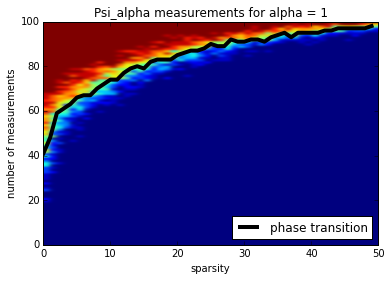

In [1]:
from IPython.display import Image
Image('exp_power_1_100.png')


In this example, we are interested in the reconstruction of sparse signals of size $N=100$. For every pixel indexed by a couple $(m,s)$ ($m$: number of measurements, $s$: sparsity parameter), we construct $15$ signals in $\R^N$ with sparsity $s$ and we observed $m$ linear measurements for each one of those signals. In the example, the measurement vectors were constructed from $N$ i.i.d. *exponential symmetric* random variables. Every time the Basis Pursuit procedure (implemented here via cvx LP solver) reconstructs all of the $15$ signals, a red pixel is drawn. When none of the $15$ signals are recovered a blue pixel is drawn. And for every results in between, an other color is drawn. 

Phase transition diagrams are used for at least two reasons:
> 1) compare procedures (like BP, IHT, OMP, etc) and algorithms used to implement those procedures

>2) compare measurement matrices (constructed from various random variables or structured measurements or determinsitic matrices)

The idea is that procedures / algorithms / measurement matrices are better when their phase transition curves (obtained when the number of failures becomes larger than the number of successes) are lower. For instance, below are plotted phase transition curves for various measurements matrices.


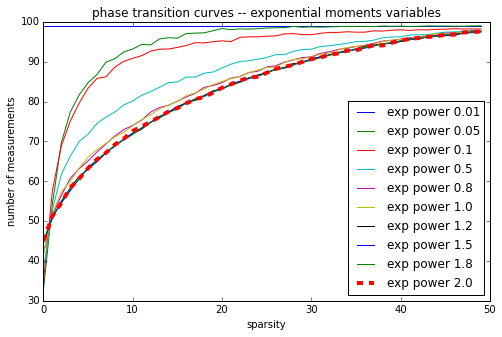

In [2]:
Image('phase_transition_curves_exp_power_100_v3.png')

One can see that measurements matrices with *exponential power $2$* are better.

In this notebook, we consider the Basis Pursuit procedure -- (BP). It can be recast to a linear program. We use the optimization library *cvxopt* to solve this linear program. An introduction to this library is provided for pedagogical purpose.

In [0]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

## Compressed sensing -- presentation of the problem
In Compressed sensing, one is given a measurement matrice $A\in\R^{m\times N}$ and a measures vector $y=Ax$ of some unknown signal $x\in\R^N$. We want to reconstruct exactly $x$ given $y$ and $A$. 

One way to look at this problem is as a highly underdetermined linear system: one has $m$ equations but $N>>m$ unknown variables. So what is going to save the day is that the signal to recover has a short support of size $s$ where $s<<N$. 

A classical procedure is the Basis Pursuit:
$$ \hat x \in\argmin_{t\in\R^N: At = y}\norm{t}_1.$$
This procedure is searching for the vector with the smallest $\ell_1$-norm in the set of solutions to the equation $Ax=y$.

## Construction and representation of signals
In this section, we construct $s$-sparse vectors in $\R^N$ and find a good vizualization of those signals.

In [0]:
def signal(N, s):
    """Construct a signal of lenght N with s gaussian variables localized randomly and zeros everywhere else"""
    x=np.zeros(N)
    tmp=np.random.normal(loc=0.0, scale=1.0, size=s)
    idx=np.random.choice(np.arange(N), size=s, replace=True, p=np.ones(N)/N)
    x[idx]=s

    return x

In [0]:
x = signal(100,15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Représentation du vecteur x')

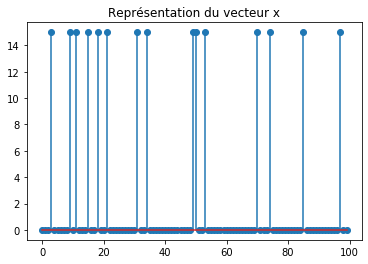

In [6]:
plt.stem(x)
titre = 'Représentation du vecteur x'
plt.title(titre)

## Construction of measurements matrices
We construct various random measurement matrices:  

1) The first one is constructed using power of Gaussian random variables: that is the measurement matrix $A$ is populated with i.i.d. random variables like $${\rm sign}(g) |g|^p$$ where $g$ is a standard Gaussian variable and $p\geq1$ is some power.

2) The second one are Student variable with degree $p$. That is a random variable absolutly continuous with a density of the order of  $(1+t)^{-(p+1)}$.

In [0]:
def measurement_matrix(m, N, rand_type = "gauss", power = 2):
    """Construct a random matrix of size (m, N) for various type of random entries"""
    if rand_type == "gauss":  
     g= np.random.normal(loc=0.0, scale=1.0, size=(m,N))
     return np.sign(g) * np.abs(g)**power 

In [0]:
A = measurement_matrix(2, 10, rand_type = "gauss")#, power = 4)

## Basis Pursuit as a linear program
One can recast the Basis Pursuit procedure as a linear program. 

Let $A\in\R^{m\times N}$ be a measurements matrix and $y\in\R^m$ be a measurements vector. We consider the following linear programming problem (LP):


> $$\min_{z^+,z^-\in\bR^N} \sum_{j=1}^n z_i^+ + z_i^-$$

> subject to $$ [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$



For any $x\in\R^N$, we denote by  $x^+\in\R^N$ and $x^-\in\R^N$ vectors with coordinates given for any $j=1,\ldots,N$ by 

\begin{equation*}
(x^+)_j = \max(0,x_j) \mbox{ et } (x^-)_j = \max(0,-x_j).
\end{equation*}

There is equivalence between the Basis Pursuit procedure and (LP) in the following way: 

>	If $\hat x$ is a solution to (BP) then $(\hat x^+, \hat x^-)$ is solution to (LP)

>	If $(\hat z^+, \hat z^-)$ is a solution to (LP) then $\hat z^+-\hat z^-$ is solution to (BP).




# Import cvxopt library for solving linear programming problems

**CVXOPT** is a very powerfull library for solving various type of convex optimization problems. We refer to examples from <a href="http://cvxopt.org/userguide/solvers.html#problems-with-nonlinear-objectives">Non-linear convex optimization</a> and <a href="http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td1a_cenonce_session9.html"> Xavier's TD9 </a>.

*solvers.cp* solves non-linear convex optimization problems with twices differentiable objective and constraint functions with closed form solutions for the gradient and the Hessian.

Here we are concerned about Linear Programming -- that is for convex optimization problems where both the objective and the constraints are linear.

In [0]:
from cvxopt import matrix, solvers, sparse, sparse, spmatrix, spdiag
solvers.options['show_progress'] = False # No logs printed

### matrix objects in cvxopt
cvxopt has its own *matrix* object which is different from the numpy's one

In [10]:
A = matrix([[1,2,3],[4,5,6]])
print(A, '-'*10, '\n',  A[1,:], '-'*10, '\n', A[::-1,::-1], '-'*10, '\n', A[0:4])
print('-'*10, '\n', A.size)

[ 1  4]
[ 2  5]
[ 3  6]
 ---------- 
 [ 2  5]
 ---------- 
 [ 6  3]
[ 5  2]
[ 4  1]
 ---------- 
 [ 1]
[ 2]
[ 3]
[ 4]

---------- 
 (3, 2)


In [11]:
A = matrix([1, 2, 3, 4, 5, 6], (2,3))
B = matrix([ [1, 2], [3, 4] ])
C = matrix([ [A] ,[B], [-A]])
D = matrix(range(16),(4,4))
E = matrix(np.ones(5))
F = matrix(np.random.randn(2,3))
G = matrix(np.zeros(2))
print(A,'-'*10, '\n', B, '-'*10, '\n', C, '-'*10, '\n', D, '-'*10, '\n', E, '-'*10, '\n', F, '-'*10, '\n', G)

[ 1  3  5]
[ 2  4  6]
 ---------- 
 [ 1  3]
[ 2  4]
 ---------- 
 [ 1  3  5  1  3 -1 -3 ... ]
[ 2  4  6  2  4 -2 -4 ... ]
 ---------- 
 [  0   4   8  12]
[  1   5   9  13]
[  2   6  10  14]
[  3   7  11  15]
 ---------- 
 [ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
 ---------- 
 [-7.89e-01 -1.19e+00 -7.44e-01]
[-2.80e-01  7.13e-01  7.08e-01]
 ---------- 
 [ 0.00e+00]
[ 0.00e+00]



In [12]:
A = matrix([[1,2,3],[4,5,6]])
B = np.array(A)
print(A, '-'*10, '\n', B)

[ 1  4]
[ 2  5]
[ 3  6]
 ---------- 
 [[1 4]
 [2 5]
 [3 6]]


### sparse matrix objects
cvxopti has its own *sparse matrix* object which is different from the scipy's one

In [0]:
E = spmatrix([1, 2], [0, 1], [0, 1], (4,2)) #(value, row, column)
B = matrix([ [1, 2], [3, 4] ])
F = sparse([ [B, B], [E] ])
G = spdiag([B, -B, 1, 2])
H = spdiag([1]*2)
K = matrix([B, -B])
K2 = matrix([[B], [-B]])
J = matrix([[B,-B, -H],[-B, B, -H]])
#print(E, '-'*30, '\n', F, '-'*30, '\n', G, '-'*30, '\n', H)
#print(K, '-'*30, '\n', K2, '-'*30, '\n', J)

## Linear programming in cvxopt (cf. <a href = 'http://cvxopt.org/userguide/coneprog.html#cvxopt.solvers.conelp'> cvxopt conelp solver </a> and <a href = 'http://cvxopt.org/userguide/coneprog.html#linear-programming'> cvxopt lp solver </a>)
Linear Programming problems in *cvxopt* have the following form
$$\min \inr{c,x} \mbox{ subject to } Gx + s =h, Ax=b, s\geq 0$$

CVXOPT command to solve this problem is 

> sol = cvxopt.solvers.lp(c, G, h[, A, b[, solver[, primalstart[, dualstart]]]])

> sol = sol['x']

The **solver** argument is used to choose among three solvers. When it is omitted or None, the CVXOPT function **conelp** is used. The external solvers **GLPK** and **MOSEK** (if installed) can be selected by setting solver to 'glpk' or 'mosek'.

Using option 'glpk' speeds up cvxopt by a factor of $2$ or $10$ (cf.  <a href = 'https://scaron.info/blog/linear-programming-in-python-with-cvxopt.html'> Stéphane Caron's webpage </a>)


# Solving (BP) via cvxopt

Let $A\in\bR^{m\times N}$ and $y\in\R^m$. (LP) is defined by:

> $$(\hat z^+, \hat z^-)\in\argmin_{(z^+,z^-)\in\bR^{2N}} \sum_{j=1}^n z_i^+ + z_i^-  \mbox{ subject to } [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$

Solution to (BP) is recovered via $t= \hat z^+- \hat z^-$.

Linear Programming problem considered in cvxopt have the following form: 


$$\min \inr{c,x} \mbox{ subject to } Gx + s =h, Ax=b, s\geq 0.$$

In the case of (LP) :

$$c = \left[\begin{array}{c} \1 \\ \1 \end{array}\right]\in\R^{2N};\hspace{1cm} G=-I_{2N}; \hspace{1cm} h = 0\in\R^{2N}; \hspace{1cm} A = [A|-A]\in\R^{m\times 2N};\hspace{1cm} b = y\in\R^m$$

### construction of cvxopt matrices $c, G, h, A, b$

In [0]:
def cvx_mat(A, y):
    m,N=A.shape
    A=matrix(A)
    c=matrix(np.ones(2*N))
    G=matrix(-np.eye(2*N))
    h=matrix(np.zeros(2*N))
    A=matrix([[A],[-A]]) 
    b=matrix(y.reshape(-1,1))
    '''A, y: numpy array or cvx matrices
    return parameters c, G, h, A, b for CVXOPT solvers.lp method'''

    return c, G, h, A, b

In [0]:
N, m, s = 1000, 50, 3
A, x = measurement_matrix(m, N), signal(N, s) 
y = np.dot(A,x)
c, G, h, A, b = cvx_mat(A, y)
#print(c, '-'*10, '\n', G,'-'*10, '\n', h,'-'*10, '\n', A,'-'*10, '\n', b)

### cvxopt linear solver  <a href="http://cvxopt.org/examples/tutorial/lp.html"> cvx lp </a>

In [0]:
sol = solvers.lp(c, G, h, A, b)#, solver = 'glpk')
sol = sol['x']
x_recover = sol[0:N] - sol[N:2*N]

In [17]:
np.linalg.norm(matrix(x) - x_recover,2)

9.985836525619307e-09

In [0]:
def dist(x, sol):
    N = len(x)
    x_recover = sol[0:N] - sol[N:2*N]
    return np.linalg.norm(matrix(x) - x_recover,2)

In [19]:
N, m, s = 500, 80, 10
A, x = measurement_matrix(m, N), signal(N, s) 
y = np.dot(A,x)
c, G, h, A, b = cvx_mat(A, y)
sol = solvers.lp(c, G, h, A, b)
sol = sol['x']
x_recover = sol[0:N] - sol[N:2*N]
print('erreur ell_2 = {}'.format(dist(x, sol)))

erreur ell_2 = 2.3700582770519996e-07


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'reconstruction')

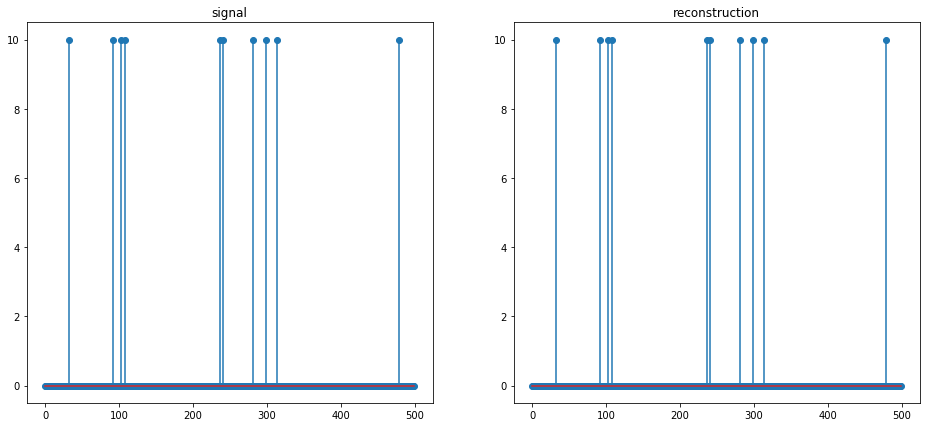

In [20]:
fig, (subfig1,subfig2) = plt.subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(x)
subfig1.set_title('signal')
subfig2.stem(x_recover)
subfig2.set_title('reconstruction')

# Phase transition diagrams for (BP)

We say that the reconstruction is a success when $||x-x_{recover}||_2\leq 0.001$

In [0]:
def phase_transition_mat(N, nbtest, rand_type = "gauss", power = 2):
    """return a N.N/2 matrix with the number of reconstruction success for every  1 < m < N measurements 
    and sparsity 1 < sparsity < N/2
    N : ambiant dimension of the signals
    nbtest : number of tests for each pixel"""
    PTM=np.zeros((N,N//2))
    for i in range(N):
      for j in range(N//2):
        for trial in range(nbtest):
          A, x = measurement_matrix(i, N), signal(N, j) 
          y = np.dot(A,x)
          c, G, h, A, b = cvx_mat(A, y)
          sol = solvers.lp(c, G, h, A, b)
          sol = sol['x']       

          if dist(x, sol) < 10**(-4):
            PTM[i,j]+=1




    return PTM

In [0]:
def frontier(mat, nbtest):
    """construction of the phase transition frontier, i.e. first time the number of success goes below nbtest/2"""
    L = []
    N = len(mat)
    for s in range(int(N/2)):
        P = 0
        while mat[P,s]<nbtest/2 and P<N-1:
            P = P + 1
        L.append(P)
    return L

In [0]:
N, nbtest = 50, 16
mat = phase_transition_mat(N, nbtest)# construction of the matrix with the number of success among nbtest

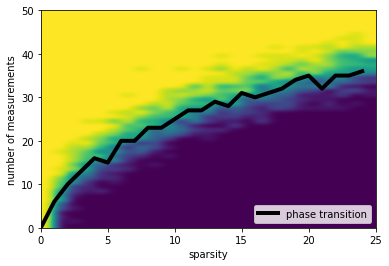

In [24]:
P_min, P_max, S_min, S_max = 0, N, 0, int(N/2)
fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent=[S_min, S_max, P_min, P_max])
plt.xlabel('sparsity')
plt.ylabel('number of measurements')

#empirical phase transition
X = range(int(N/2))
L = frontier(mat, nbtest)
plt.plot(X,L, linewidth=4, color = 'black', label='phase transition')
plt.legend(loc=4)

#filename = 'noisy_gaussian_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

### Repeat the construction of the frontier *nb_curves* times to "smooth it"

> nb_curves: number of phase transition curves constructed. Those curves are then averaged to "smooth" the effect of randomness in phase transition and get a "stable" phase transition

In [25]:
#n, eps, nbtest = 100, 0.1, 16
nb_curves = 5
L = np.zeros(int(N/2))
for i in range(nb_curves):
    
    print('step {} done'.format(i))
    mat = phase_transition_mat(N, nbtest)
    F = frontier(mat, nbtest)
    L = [sum(a) for a in zip(L,F)] 
L_gauss = [i/nb_curves for i in L]

step 0 done


In [0]:
#For next use, save the Gaussian phase transition frontier in a txt file 
import pickle
filename = 'phase_transition_diagram_N_{}_nbtest_{}_nbcurves.p'.format(N, nbtest, nb_curves)
with open(filename, "wb") as f:
    pickle.dump(L_gauss, f)

#import the phase transition diagram
#filename = 'phase_transition_diagram_N_{}_nbtest_{}_nbcurves.p'
#with open(filename, "rb") as inputfile:
#    L_gauss = pickle.load(inputfile)
#L_gauss = [int(float(ele[0])) for ele in L_gauss]

### Draw the phase transition frontier of the Basis Pursuit procedure (via cvx.lp) for Gaussian measurements

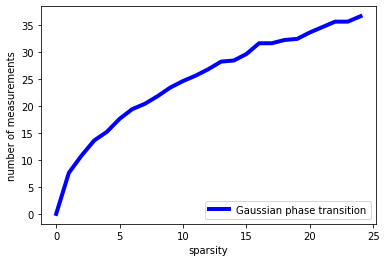

In [28]:
X = range(len(L_gauss))
plt.plot(X,L_gauss, linewidth=4, color = 'blue', label="Gaussian phase transition")

plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.legend(loc=4)
#filename = 'gaussian_phase_transition_quantized_cs_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

# Measurement matrices used in the proof of the NP-hardness of the $\ell_0$-minimization procedure

NP-hardness of the $\ell_0$-minimization procedure is based on a reduction principle. One can tranform the $\ell_0$-minimization problem in polynomial time into a "classical" NP-complete problem: the **cover by $3$-sets problem**.

*Cover by $3$-sets problem*: given a collection $\cC=\{C_1, \ldots, C_N\}$ of subsets of $\{1,\ldots,m\}$ all of cardinality $3$, is it possible to answer the question about the existence of a partition of $\{1,\ldots,m\}$ within this collection?

To prove that $\ell_0$-minimization problem can be reduced to the cover by $3$-sets problem, one can consider the following measurement vector
$$
y = \left(
\begin{array}{c}
1\\
1\\
\vdots\\
1\\
\end{array}
\right)
$$
and a measurement matrix:
$$
A=[1_{C_1}| \cdots | 1_{C_N}]
$$
where $1_{C_1}$ is a vector in $\R^m$ such that $(1_{C_1})_i = 1$ if $i\in C_1$ and $0$ if $i\notin C_1$. 

One can see that a solution to the $\ell_0$-minimization procedure $\hat x_0$ obtained from $y$ and $A$ can be used to answer the *cover by $3$-sets problem*: if $\norm{\hat x_0}=m/3$ then there is a partition of $\{1,\ldots,m\}$ in the collection $\cC$; if $\norm{\hat x_0}>m/3$ then there is no such a partition (and one can show that necessarily  $\norm{\hat x_0}\geq m/3$).

Hence solving the $\ell_0$-minimization procedure for this $y$ and $A$ can be reduced in polynomial time to a solution of an NP-complete problem (and so by definition $\ell_0$-minimization is an NP-Hard problem).

## Phase transition of (BP) for the $0-1$ matrix $A$
We construct matrices $A$ introduced in the last paragraph in the two cases: either there is a partition and so the solution of the $\ell_0$-minimization problem should have a support of size $m/3$ either there is no partition and so $\hat x_0$ should have a strictly larger support. 

We want to check the performances of (BP) in this setup. We expect it to fail otherwise this would give a polynomial time algorithm to solve an NP-hard problem.

In [0]:
def measurement_mat_partition(N, m, partition = 'yes', shuffling = 'yes'):
    """Construct the matrices used in the proof of the NP-hardness of \ell_0 in the two cases"""
    A=np.zeros((N,m))
    for i in range(N):
      C=list(np.random.choice(np.arange(m), size=3, replace=True))
      for j in range(m):
         if j in  C:
           A[i,j]=1
    return np.transpose(A)

In [0]:
def measures_vectors(m):
    return np.ones(m)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<StemContainer object of 3 artists>

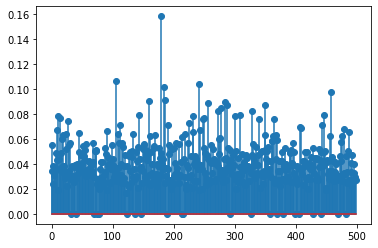

In [39]:
N, m = 500, 3*20
A = measurement_mat_partition(N, m, partition = 'yes', shuffling ='no') 
y = measures_vectors(m)
c, G, h, A, b = cvx_mat(A, y)
sol = solvers.lp(c, G, h, A, b)
sol = sol['x']
x_recover = sol[0:N] - sol[N:2*N]
plt.stem(x_recover)

Basis Pursuit does not work for this type of $0-1$ valued measurement matrices.